In [2]:
!pip install facenet-pytorch  # Install facenet-pytorch for face detection and alignment

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 51.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 83.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 87.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 755.6/755.6 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 100.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 80.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 46.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.

In [2]:
!pip install torchvision  # Install torchvision for image transformations

In [3]:
!pip install --upgrade pillow  # Upgrade Pillow to ensure compatibility with image processing

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 84.7 MB/s eta 0:00:00
  Attempting uninstall: pillow
    Found existing installation: pillow 10.2.0
    Uninstalling pillow-10.2.0:
      Successfully uninstalled pillow-10.2.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
facenet-pytorch 2.6.0 requires Pillow<10.3.0,>=10.2.0, but you have pillow 11.3.0 which is incompatible.


In [1]:
# Face Recognition with Cosine Similarity Matching
# =================================================
# Well-documented notebook for evaluating face recognition on distorted images
# using a pretrained model (InceptionResnetV1 from facenet-pytorch).
#
# Requirements:
# - facenet-pytorch
# - torch, torchvision
# - sklearn
# - numpy, pillow, matplotlib

import os
import numpy as np
from tqdm import tqdm
from PIL import Image, ImageEnhance
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics.pairwise import cosine_similarity
from facenet_pytorch import InceptionResnetV1, MTCNN
from torchvision import transforms
import torch

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Device setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Paths
train_dir = "/content/drive/MyDrive/Comys_Hackathon5/Task_B/train"
val_dir = "/content/drive/MyDrive/Comys_Hackathon5/Task_B/val"  # Change this path to test dataset as needed

# Load FaceNet
facenet = InceptionResnetV1(pretrained='vggface2', classify=False).eval().to(device)
mtcnn = MTCNN(image_size=160, margin=20, keep_all=False, device=device)

  0%|          | 0.00/107M [00:00<?, ?B/s]

In [4]:
# Test-Time Augmentation (TTA)
def tta_embeddings(img):
    faces = []
    enhancers = [
        lambda x: x,
        lambda x: ImageEnhance.Brightness(x).enhance(1.2),
        lambda x: ImageEnhance.Sharpness(x).enhance(2.0),
        lambda x: ImageEnhance.Contrast(x).enhance(1.5)
    ]
    for enhance in enhancers:
        aug_img = enhance(img)
        face = mtcnn(aug_img)
        if face is not None:
            with torch.no_grad():
                emb = facenet(face.unsqueeze(0).to(device))
                faces.append(emb.squeeze().cpu().numpy())
    return faces

# Get average TTA embedding
def get_embedding(image_path):
    try:
        img = Image.open(image_path).convert('RGB')
        embs = tta_embeddings(img)
        if embs:
            return np.mean(embs, axis=0)
        return None
    except:
        return None

In [5]:
def build_reference_embeddings(train_dir):
    embeddings, labels = [], []
    for person_name in tqdm(os.listdir(train_dir)):
        person_path = os.path.join(train_dir, person_name)
        if not os.path.isdir(person_path):
            continue
        for file in os.listdir(person_path):
            image_path = os.path.join(person_path, file)
            if os.path.isdir(image_path):
                continue  # skip directories
            try:
                img = Image.open(image_path).convert('RGB')
                emb = tta_embeddings(img)
                embeddings.append(emb)
                labels.append(person_name)
            except Exception as e:
                print(f"[ERROR] Skipping file: {image_path} due to {e}")
    return np.vstack(embeddings), labels


In [9]:
# Build validation feature database
val_features = {}
print("\nFeature Extraction for Validation Set:")
for person_name in tqdm(os.listdir(val_dir)):
    person_path = os.path.join(val_dir, person_name)
    if not os.path.isdir(person_path):
        continue
    embeddings = []
    for file in os.listdir(person_path):
        image_path = os.path.join(person_path, file)
        if os.path.isdir(image_path):
            continue  # skip directories
        emb = get_embedding(image_path)
        if emb is not None:
            embeddings.append(emb)
    if embeddings:
        val_features[person_name] = np.array(embeddings)


Feature Extraction for Validation Set:


100%|██████████| 250/250 [17:24<00:00,  4.18s/it]


In [10]:
# Match distorted images
results = []
similarity_scores = []
print("\n🔍 Matching distorted images:")
for person in tqdm(os.listdir(val_dir)):
    distortion_path = os.path.join(val_dir, person, "distortion")
    if not os.path.isdir(distortion_path):
        continue

    for file in os.listdir(distortion_path):
        file_path = os.path.join(distortion_path, file)
        embedding = get_embedding(file_path)
        if embedding is None:
            continue

        best_person = None
        best_score = -1

        for known_person, embeddings in val_features.items():
            sims = cosine_similarity([embedding], embeddings)
            max_sim = np.max(sims)
            if max_sim > best_score:
                best_score = max_sim
                best_person = known_person

        match = 1 if best_person == person and best_score > 0.65 else 0
        results.append((file, person, best_person, best_score, match))
        similarity_scores.append(best_score)



🔍 Matching distorted images:


100%|██████████| 250/250 [2:04:33<00:00, 29.90s/it] 


In [13]:
import random

# Output random 10 sample results
print("\n📊 Sample Results (random 10):")
sampled_results = random.sample(results, min(10, len(results)))
for r in sampled_results:
    print(f"{r[0]} | True: {r[1]} | Predicted: {r[2]} | Similarity: {r[3]:.4f} | Match: {r[4]}")

# Evaluation
true_labels = [r[1] for r in results]
pred_labels = [r[2] if r[4] == 1 else "wrong" for r in results]
valid_results = [r for r in results if r[4] == 1]
true_valid = [r[1] for r in valid_results]
pred_valid = [r[2] for r in valid_results]

top1_acc = accuracy_score(true_labels, pred_labels)
macro_f1 = f1_score(true_valid, pred_valid, average='macro') if true_valid else 0.0

print(f"\n✅ Top-1 Accuracy: {top1_acc:.4f}")
print(f"✅ Macro-Averaged F1 Score: {macro_f1:.4f}")


📊 Sample Results (random 10):
Larry_Coker_0003_noisy.jpg | True: Larry_Coker | Predicted: Larry_Coker | Similarity: 0.4004 | Match: 0
Harrison_Ford_0005_rainy.jpg | True: Harrison_Ford | Predicted: Harrison_Ford | Similarity: 0.5233 | Match: 0
Fernando_Valenzuela_0001_resized.jpg | True: Fernando_Valenzuela | Predicted: Fernando_Valenzuela | Similarity: 0.9965 | Match: 1
Fran_Drescher_0001_foggy.jpg | True: Fran_Drescher | Predicted: Fran_Drescher | Similarity: 0.8516 | Match: 1
Thomas_Manger_0001_lowlight.jpg | True: Thomas_Manger | Predicted: Thomas_Manger | Similarity: 0.9477 | Match: 1
Candice_Bergen_0003_foggy.jpg | True: Candice_Bergen | Predicted: Candice_Bergen | Similarity: 0.9005 | Match: 1
Hung_Wan-ting_0001_rainy.jpg | True: Hung_Wan-ting | Predicted: Eric_Hinske | Similarity: 0.4851 | Match: 0
Wen_Jiabao_0003_noisy.jpg | True: Wen_Jiabao | Predicted: Wen_Jiabao | Similarity: 0.7493 | Match: 1
Tim_Floyd_0002_lowlight.jpg | True: Tim_Floyd | Predicted: Tim_Floyd | Similarit

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt
# Threshold tuning
SIMILARITY_THRESHOLD = 0.65  # Initial threshold based on observations

def threshold_curve(results, thresholds=np.linspace(0.3, 0.95, 50)):
    acc_list, f1_list = [], []

    for thresh in thresholds:
        y_true = [r['true'] for r in results]
        y_pred = [
            r['pred'] if (r['score'] > thresh and r['pred'] == r['true']) else "wrong"
            for r in results
        ]
        valid = [
            r for r in results if r['score'] > thresh and r['pred'] == r['true']
        ]
        true_valid = [r['true'] for r in valid]
        pred_valid = [r['pred'] for r in valid]

        acc = accuracy_score(y_true, y_pred)
        f1 = f1_score(true_valid, pred_valid, average='macro', zero_division=0)

        acc_list.append(acc)
        f1_list.append(f1)

    plt.figure(figsize=(8, 5))
    sns.set_style("whitegrid")
    plt.plot(thresholds, acc_list, label="Top-1 Accuracy", color='darkorange', marker='o')
    plt.plot(thresholds, f1_list, label="Macro F1 Score", color='teal', marker='s')
    plt.axvline(SIMILARITY_THRESHOLD, color='red', linestyle='--', label='Current Threshold')
    plt.xlabel("Similarity Threshold")
    plt.ylabel("Score")
    plt.title("Threshold Tuning Curve")
    plt.legend()
    plt.tight_layout()
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.show()

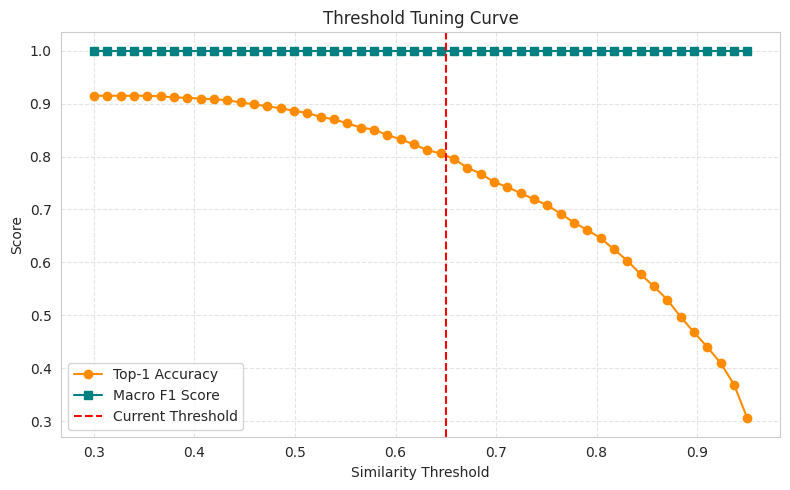

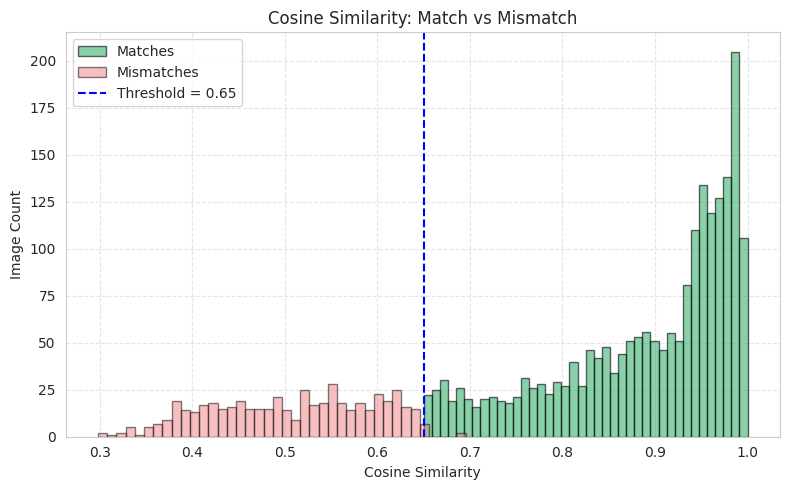

In [15]:
# Prepare results in dict format for plotting
structured_results = [
    {'file': r[0], 'true': r[1], 'pred': r[2], 'score': r[3], 'match': r[4]}
    for r in results
]

# Plot threshold tuning curve
threshold_curve(structured_results)

# Plot cosine similarity histogram
match_scores = [r['score'] for r in structured_results if r['match'] == 1]
mismatch_scores = [r['score'] for r in structured_results if r['match'] == 0]

plt.figure(figsize=(8, 5))
sns.set_style("whitegrid")
plt.hist(match_scores, bins=40, alpha=0.6, label="Matches", color='mediumseagreen', edgecolor='black')
plt.hist(mismatch_scores, bins=40, alpha=0.5, label="Mismatches", color='lightcoral', edgecolor='black')
plt.axvline(SIMILARITY_THRESHOLD, color='blue', linestyle='--', label=f'Threshold = {SIMILARITY_THRESHOLD}')
plt.title("Cosine Similarity: Match vs Mismatch")
plt.xlabel("Cosine Similarity")
plt.ylabel("Image Count")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


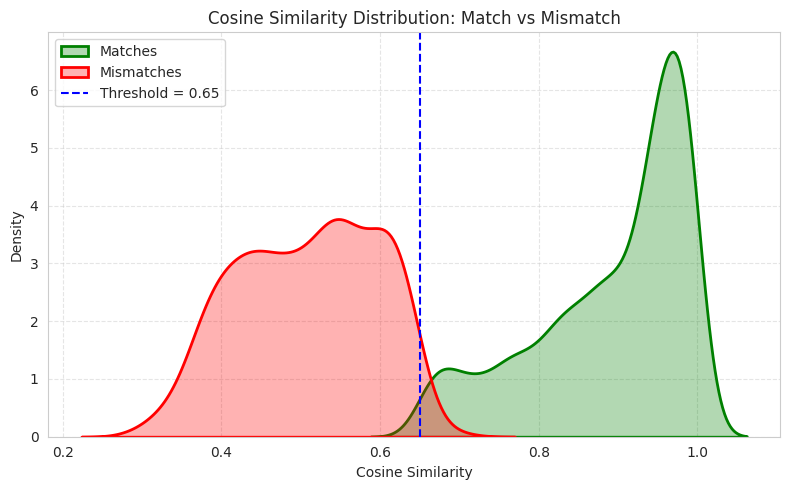

In [16]:
# KDE plot for match vs mismatch
plt.figure(figsize=(8, 5))
sns.set_style("whitegrid")
sns.kdeplot(match_scores, label='Matches', color='green', linewidth=2, fill=True, alpha=0.3)
sns.kdeplot(mismatch_scores, label='Mismatches', color='red', linewidth=2, fill=True, alpha=0.3)
plt.axvline(SIMILARITY_THRESHOLD, color='blue', linestyle='--', label=f'Threshold = {SIMILARITY_THRESHOLD}')
plt.title("Cosine Similarity Distribution: Match vs Mismatch")
plt.xlabel("Cosine Similarity")
plt.ylabel("Density")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()
